# Fitbit Exploration
For an explanation on the variables, take a look at the [data dictionary created by Fitabase](https://www.fitabase.com/media/1546/fitabasedatadictionary.pdf). 

Link to help create a table of contents is [here](https://sebastianraschka.com/Articles/2014_ipython_internal_links.html).

In [248]:
import warnings
warnings.filterwarnings('ignore')

# Sleep Sensitivity
In this notebook we take a look at the variables that might be affecting sleep the most.

In [249]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data_import)
    1. [Labels](#labels)
    2. [Features](#features)
        1. Complete
        2. IEQ
        3. Mood
        4. Self-Report Sleep
        5. Fitbit Activity
2. [Analysis](#analysis)
    1. [Feature Engineering](#feature_engineering)
        1. [Mutual Information](#mutual_information)

In [250]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='data_import'></a>

# Data Import
We have a spate of data available to us from the three main modalities: beacon, Fitbit, and Beiwe. Each of these datasets can be analyzed individually or all together. Each of these datasets has already been created via the `build_features` source code.

<a id='labels'></a>

## Labels
We can start by importing the labels dataset: Fitbit sleep metrics.

In [251]:
labels = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time"])
labels.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,2950.000000,1724.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000
mean,3.732711,77.101962,28.256031,243.267289,9.386619,86.384690,30.306208,63.342232,91.695722,40.865763,21.473898,31.988742,0.307744,320.369251,0.274370,7.834936
std,1.468774,25.795931,8.626905,55.887225,4.294173,30.717377,9.232387,19.729932,8.480847,21.837114,11.936372,9.339972,0.148229,64.050766,0.095751,1.524611
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,27.000000,0.000000,1.000000,5.000000,0.000000,116.000000,0.000000,3.033333
25%,3.000000,60.000000,22.000000,208.000000,6.000000,66.000000,24.000000,50.000000,91.000000,23.000000,13.000000,26.000000,0.200000,284.000000,0.210526,7.000000
50%,4.000000,77.000000,28.000000,242.000000,9.000000,87.000000,30.000000,62.000000,93.000000,45.000000,21.000000,32.000000,0.285714,323.000000,0.272727,7.900000
75%,5.000000,94.000000,34.000000,278.000000,12.000000,107.000000,36.000000,75.000000,96.000000,56.000000,29.000000,38.000000,0.388889,360.000000,0.338542,8.783333
max,10.000000,177.000000,64.000000,598.000000,28.000000,219.000000,66.000000,174.000000,100.000000,87.000000,46.000000,68.000000,1.142857,775.000000,0.778409,17.683333


<a id='features'></a>

## Features
Next we can import the various datasets that can be used for the features. We start with the most complete dataset and trickle down from there.

### Complete Features Dataset
This dataset, while short, is the most comprehensive and includes overlapping data from all modalities.

In [252]:
features_complete = pd.read_csv("../data/processed/all_modalities-fb_and_gps_filtered-ux_s20.csv",parse_dates=["start_time","end_time"])
features_complete.describe()

,lat_mean,long_mean,altitude_mean,accuracy_mean,tvoc_mean,lux_mean,no2_mean,co_mean,co2_mean,pm1_number_mean,pm2p5_number_mean,pm10_number_mean,pm1_mass_mean,pm2p5_mass_mean,pm10_mass_mean,temperature_c_mean,rh_mean,beacon,fitbit,redcap,lat_median,long_median,altitude_median,accuracy_median,tvoc_median,lux_median,no2_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,lat_delta,long_delta,altitude_delta,accuracy_delta,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm1_number_delta,pm2p5_number_delta,pm10_number_delta,pm1_mass_delta,pm2p5_mass_delta,pm10_mass_delta,temperature_c_delta,rh_delta,lat_delta_percent,long_delta_percent,altitude_delta_percent,accuracy_delta_percent,tvoc_delta_percent,lux_delta_percent,no2_delta_percent,co_delta_percent,co2_delta_percent,pm1_number_delta_percent,pm2p5_number_delta_percent,pm10_number_delta_percent,pm1_mass_delta_percent,pm2p5_mass_delta_percent,pm10_mass_delta_percent,temperature_c_delta_percent,rh_delta_percent,content_morning,stress_morning,lonely_morning,sad_morning,energy_morning,tst,sol,naw,restful,content_evening,stress_evening,lonely_evening,sad_evening,energy_evening,calories,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,15.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,31.708245,-97.281673,183.152029,226.326105,251.450812,2.584985,1.040589,2.675229,1005.861635,6.940623,7.297195,7.339740,0.529240,1.264329,2.180827,26.794703,42.677904,21.826087,28.521739,44.000000,31.708215,-97.281549,183.926963,46.372968,251.636715,2.134963,1.068903,2.598729,1002.601932,6.641631,7.035111,7.086057,0.513637,1.251939,2.169061,26.755616,42.614130,0.002767,0.005028,9.797499,2762.532037,145.283333,7.662299,0.216908,1.548383,231.177142,8.077241,8.590784,8.665080,0.561023,0.988647,1.018249,1.450725,3.604710,0.008496,-0.005184,6.285770,51440.372741,inf,inf,-53.704067,127.955648,29.344919,1091.017982,3660.212034,2481.321599,395.931490,117.457011,58.275877,5.728423,8.640482,2.347826,0.695652,0.130435,0.086957,2.391304,6.760870,13.173913,1.782609,2.130435,2.347826,0.521739,0.217391,0.086957,2.478261,2168.956522,7594.739130,3.272456,706.434783,187.826087,16.695652,25.391304,874.260870,3.826087,74.695652,28.043478,247.695652,8.434783,78.913043,29.521739,63.347826,93.173913,31.869565,0.277568,322.391304,0.244884,7.744203
std,1.406060,0.400138,17.965757,196.406064,86.479202,6.985300,0.146838,2.892325,305.096311,4.755816,4.742392,4.693987,0.302098,0.299442,0.230945,2.134758,5.469532,10.002964,12.090077,18.466185,1.406037,0.400200,17.193880,23.869096,88.165647,6.447158,0.208614,2.890972,311.805323,4.614899,4.677822,4.627979,0.297801,0.290936,0

### IEQ Features Dataset
Arguably the most restrictive dataset after the complete set, we can import the IEQ features from the beacon. We have to do a little pre-processing first to remove the GPS features and any column that ends with "percent" since these data are bad. 

In [253]:
ieq_data = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time"])
features_ieq = ieq_data.merge(right=labels,left_on=["start_time","end_time","beacon","redcap","beiwe"],right_on=["start_time","end_time","beacon","redcap","beiwe"])
features_ieq.drop([c for c in features_ieq.columns if c.endswith("percent")],axis="columns",inplace=True)
for gps_label in ["long","lat","accuracy","altitude"]:
    features_ieq.drop([c for c in features_ieq.columns if c.startswith(gps_label)],axis="columns",inplace=True)
features_ieq.describe()

,tvoc_mean,lux_mean,no2_mean,co_mean,co2_mean,pm1_number_mean,pm2p5_number_mean,pm10_number_mean,pm1_mass_mean,pm2p5_mass_mean,pm10_mass_mean,temperature_c_mean,rh_mean,beacon,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm1_number_delta,pm2p5_number_delta,pm10_number_delta,pm1_mass_delta,pm2p5_mass_delta,pm10_mass_delta,temperature_c_delta,rh_delta,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
count,225.000000,224.000000,120.000000,226.000000,226.000000,212.000000,212.000000,212.000000,212.000000,212.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,225.000000,224.000000,120.000000,226.000000,226.000000,212.000000,212.000000,212.000000,212.000000,212.000000,226.000000,226.000000,226.000000,225.000000,224.000000,120.000000,226.000000,226.000000,212.000000,212.000000,212.000000,212.000000,212.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
mean,265.534761,3.332562,1.079495,2.609954,969.410538,8.507479,8.825611,8.851313,0.619491,1.346435,2.124992,26.944455,42.659180,23.561947,30.592920,43.292035,261.623444,2.696463,1.079890,2.580662,966.848844,8.073657,8.413720,8.438968,0.593751,1.321277,2.107642,26.947087,42.587525,167.211975,9.025819,0.122769,1.106574,194.775597,9.720924,10.125966,10.170523,0.648698,1.064177,0.998584,1.277028,3.288397,3.513274,72.460177,27.486726,247.323009,9.203540,83.336283,29.761062,62.128319,93.176991,31.000000,0.307303,319.783186,0.262753,7.754130
std,144.383798,7.050839,0.326953,2.614681,376.737318,9.678663,9.429568,9.290298,0.595378,0.558059,0.606684,1.907365,5.569048,10.776030,11.793887,16.737812,142.637621,6.958426,0.327470,2.597982,377.358531,9.102868,8.905938,8.795275,0.562893,0.538596,0.600255,1.919237,5.480965,163.335493,14.431962,0.206673,1.497328,161.792600,14.050166,13.385237,13.141243,0.867057,0.847131,0.813763,0.775867,2.283233,1.320707,27.657118,7.349213,53.928983,4.212488,31.221819,7.824491,17.953431,6.307992,7.992775,0.147707,59.833412,0.093673,1.468539
min,19.016547,0.000000,-0.276564,-0.031249,421.230566,0.116044,0.469432,0.598738,0.088306,0.654342,0.546604,23.000000,31.449031,1.000000,9.000000,10.000000,9.500000,0.000000,-0.276482,-0.038750,419.238070,0.116044,0.469432,0.598738,0.080327,0.654342,0.546604,23.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,51.000000,0.000000,0.000000,7.000000,22.000000,44.000000,11.000000,0.000000,117.000000,0.000000,3.066667
25%,193.786395,0.007692,0.949357,1.010439,732.437325,2.388951,2.718550,2.836187,0.244587,0.964852,1.926184,25.241973,39.198507,17.500000,16.000000,36.000000,188.458333,0.000000,0.962680,0.992400,728.198673,2.214961,2.465948,2.501066,0.230586,0.952692,1.912542,25.000000,39.398958,84.466667,0.000000,0.034163,0.322529,96.157164,3.495808,4.243369,4.397412,0.283621,0.673280,0.622077,1.000000,2.000000,3.000000,54.250000,23.000000,222.000000,6.000000,65.000000,25.000000,51.000000,92.000000,26.000000,0.192618,292.250000,0.210966,6.987500
50%,239.581167,0.514521,1.083818,2.187965,889.380722,6.536288,7.063853,7.145993,0.488058,1.239731,2.100994,27.198730,41.777573,21.000000,37.000000,42.000000,236.975000,0.000000,1.083311,2.107850,879.716201,6.298459,6.915787,6.960081,0.483708,1.179588,2.067093,27.000000,42.000000,131.366667,2.373200,0.046670,0.799900,165.363558,5.737971,6.388136,6.564257,0.417866,0.908427,0.900299,1.000000,2.925000,3.000000,75.000000,27.000000,252.000000,9.000000,87.000000,29.500000,60.000000,94.000000,30.000000,0.3000

### Self-Report Mood Features Dataset
A more complex relationship

In [254]:
features_mood = pd.read_csv("../data/processed/beiwe_fitbit-evening_mood_and_sleep-ux_s20.csv",parse_dates=["start_date","end_date","start_time","end_time"])
features_mood.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,content,stress,lonely,sad,energy
count,641.000000,641.000000,641.00000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,474.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000
mean,3.594384,74.964119,28.74883,247.928237,9.099844,87.430577,30.393136,64.536661,92.427457,40.783151,20.556962,32.343214,0.297643,322.892356,0.275132,7.914327,2.156006,0.811232,0.575663,0.408736,2.031201
std,1.442946,25.062926,9.04542,56.491076,4.300002,32.056814,9.371243,19.464687,7.952680,20.435908,10.027548,9.757088,0.151104,63.062340,0.096930,1.516717,0.833291,0.892818,0.827817,0.750948,1.086405
min,1.000000,6.000000,4.00000,51.000000,0.000000,0.000000,5.000000,14.000000,27.000000,0.000000,1.000000,5.000000,0.000000,117.000000,0.000000,3.333333,-1.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,2.000000,58.000000,23.00000,212.000000,6.000000,65.000000,25.000000,52.000000,91.000000,23.000000,13.000000,26.000000,0.186047,286.000000,0.214085,7.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,4.000000,76.000000,28.00000,247.000000,9.000000,88.000000,30.000000,63.000000,94.000000,42.000000,21.000000,32.000000,0.272727,326.000000,0.276094,8.033333,2.000000,1.000000,0.000000,0.000000,2.000000
75%,4.000000,92.000000,34.00000,284.000000,12.000000,110.000000,36.000000,75.000000,96.000000,58.000000,27.250000,38.000000,0.384615,361.000000,0.338624,8.916667,3.000000,1.000000,1.000000,1.000000,3.000000
max,9.000000,148.000000,64.00000,426.000000,28.000000,209.000000,66.000000,136.000000,100.000000,86.000000,44.000000,68.000000,0.863636,540.000000,0.585153,14.650000,3.000000,3.000000,3.000000,3.000000,4.000000


### Self-Report Sleep Metric (SRSM) Features Dataset
The feature set that should have the greatest relationship with the Fitbit since it is another measure of sleep quality. 

In [255]:
features_srsm = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"])
features_srsm.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,tst_ema,sol_ema,naw_ema,restful_ema
count,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,683.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000
mean,3.648446,75.468382,28.394427,246.593783,9.248660,85.070740,30.309753,62.345123,92.125402,40.131833,20.793558,32.042872,0.301077,322.062165,0.267373,7.824634,6.929636,18.329582,1.730975,1.979636
std,1.396151,25.213984,8.386253,55.837700,4.465931,30.995489,9.009621,18.854846,8.116661,20.149569,11.271892,9.006572,0.151195,62.321198,0.091420,1.498144,1.340100,21.023896,1.704411,0.827772
min,0.000000,0.000000,7.000000,87.000000,0.000000,0.000000,5.000000,14.000000,27.000000,0.000000,1.000000,9.000000,0.000000,126.000000,0.000000,3.033333,-1.000000,-1.000000,-1.000000,-1.000000
25%,3.000000,60.000000,23.000000,210.000000,6.000000,64.000000,25.000000,50.000000,91.000000,27.000000,13.000000,26.000000,0.188679,285.000000,0.208163,6.950000,6.000000,6.000000,1.000000,2.000000
50%,4.000000,76.000000,28.000000,244.000000,9.000000,85.000000,30.000000,61.000000,94.000000,42.000000,21.000000,32.000000,0.272727,324.000000,0.268482,7.866667,7.000000,15.000000,2.000000,2.000000
75%,4.000000,91.000000,34.000000,281.000000,12.000000,106.000000,36.000000,73.000000,96.000000,58.000000,29.000000,38.000000,0.382353,361.000000,0.334337,8.766667,8.000000,20.000000,2.000000,3.000000
max,9.000000,148.000000,61.000000,458.000000,24.000000,209.000000,63.000000,145.000000,100.000000,85.000000,44.000000,66.000000,1.125000,540.000000,0.590000,14.650000,12.000000,240.000000,15.000000,3.000000


### Fitbit Activity Features Dataset
The largest and final features set is the activity data from Fitbit which should be the closest match to all Fitbit sleep data we have since both are collected from the same source.

In [256]:
features_activity = pd.read_csv("../data/processed/fitbit_fitbit-daily_activity_and_sleep-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"])
features_activity.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,calories,bmr,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,fat,weight,food_calories_logged,water_logged
count,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,2843.000000,1654.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000
mean,3.734177,77.019987,28.243171,242.986009,9.387075,86.241839,30.301799,63.497335,91.736842,40.992613,21.375453,31.977348,0.307748,320.005996,0.274237,7.829086,2170.781479,1429.503997,7445.032978,3.262410,744.418388,206.360426,16.420386,20.581945,902.806462,22.289431,1.664820,134.761209,105.276149,1.852765
std,1.469888,25.776219,8.597763,55.765305,4.307345,30.854521,9.217585,19.717114,8.375837,21.792209,11.847433,9.312389,0.148590,63.956682,0.096230,1.525016,523.857979,202.346895,5340.182326,2.471111,192.580767,98.976801,25.485015,30.894012,514.843061,2.943300,6.031096,22.517273,441.928007,10.833245
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,27.000000,0.000000,1.000000,5.000000,0.000000,116.000000,0.000000,3.033333,1049.000000,1046.000000,4.000000,0.001616,0.000000,0.000000,0.000000,0.000000,0.000000,18.037397,0.000000,96.990000,0.000000,0.000000
25%,3.000000,60.000000,22.000000,208.000000,6.000000,66.000000,24.000000,50.000000,91.000000,23.000000,13.000000,26.000000,0.200000,284.000000,0.210526,7.000000,1807.250000,1255.000000,3482.250000,1.451195,633.000000,141.000000,0.000000,0.000000,533.000000,20.312498,0.000000,118.000000,0.000000,0.000000
50%,4.000000,77.000000,28.000000,242.000000,9.000000,86.000000,30.000000,62.000000,93.000000,45.000000,21.000000,32.000000,0.285714,322.000000,0.272270,7.883333,2097.000000,1365.000000,6226.500000,2.658468,729.000000,194.000000,7.000000,5.000000,818.500000,21.659504,0.000000,130.000000,0.000000,0.000000
75%,5.000000,94.000000,34.000000,278.000000,12.000000,106.000000,36.000000,75.000000,96.000000,58.000000,29.000000,38.000000,0.388889,359.000000,0.338101,8.783333,2448.000000,1551.000000,10177.250000,4.504787,820.000000,257.000000,21.000000,33.000000,1171.750000,24.274609,0.000000,140.000000,0.000000,0.000000
max,10.000000,177.000000,61.000000,598.000000,28.000000,219.000000,64.000000,174.000000,100.000000,87.000000,46.000000,66.000000,1.142857,775.000000,0.778409,17.683333,5437.000000,1910.000000,37485.000000,17.323717,1440.000000,636.000000,198.000000,275.000000,4242.000000,31.822655,25.224001,193.600000,3054.000000,120.000000


<a id='analysis'></a>

# Analysis
The analysis section is outlined as followed:

- [Target Data Cleaning and Visualization](#target_data)
- [Feature Engineering](#feature_engineering)

<a id='target_data'></a>

## Target Data Cleaning and Visualization
We can gain a bit more insight into the target data by plotting the available data in various forms. There might also be some targets that could benefit from a bit of cleaning. The general outline is as follows:

- [Summary](#summary)
- [Cleaning](#cleaning)

Much of this code has been refractured into the `processing` source code and we import that module below so that we can simplify the code presented in this notebook.

<a id='summary'></a>

In [257]:
from src.processing import process
# defining feature engineering object
pp = process.preprocess()

### Summary
Here we look at summarizing data and figures to get a sense of the target data we are considering. We will start by removing some columns that are not necessary for analysis.

In [258]:
targets = labels[[column for column in labels.columns if column not in ['start_date','end_date','beiwe','end_time','redcap','beacon']]]
targets.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000
mean,3.732711,77.101962,28.256031,243.267289,9.386619,86.384690,30.306208,63.342232,91.695722,31.988742,0.307744,320.369251,0.274370,7.834936
std,1.468774,25.795931,8.626905,55.887225,4.294173,30.717377,9.232387,19.729932,8.480847,9.339972,0.148229,64.050766,0.095751,1.524611
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,27.000000,5.000000,0.000000,116.000000,0.000000,3.033333
25%,3.000000,60.000000,22.000000,208.000000,6.000000,66.000000,24.000000,50.000000,91.000000,26.000000,0.200000,284.000000,0.210526,7.000000
50%,4.000000,77.000000,28.000000,242.000000,9.000000,87.000000,30.000000,62.000000,93.000000,32.000000,0.285714,323.000000,0.272727,7.900000
75%,5.000000,94.000000,34.000000,278.000000,12.000000,107.000000,36.000000,75.000000,96.000000,38.000000,0.388889,360.000000,0.338542,8.783333
max,10.000000,177.000000,64.000000,598.000000,28.000000,219.000000,66.000000,174.000000,100.000000,68.000000,1.142857,775.000000,0.778409,17.683333


<a id='feature_engineering'></a>

#### Distributions

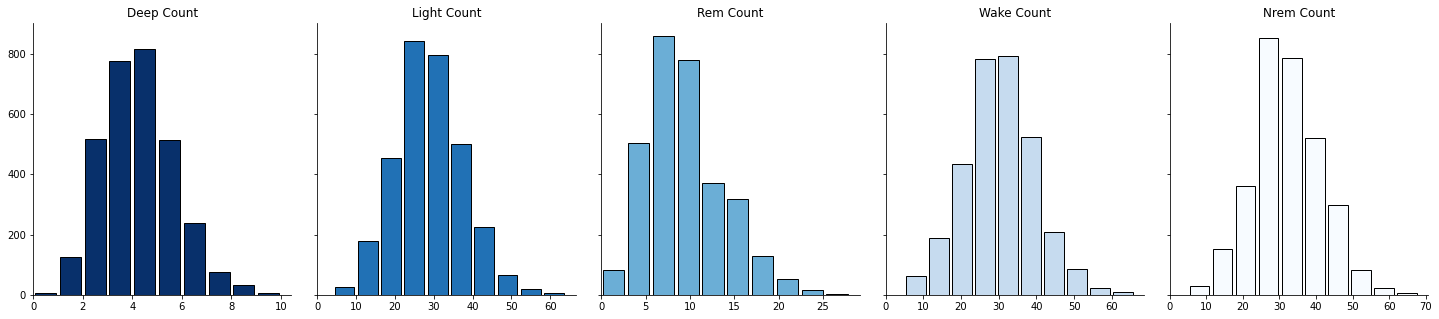

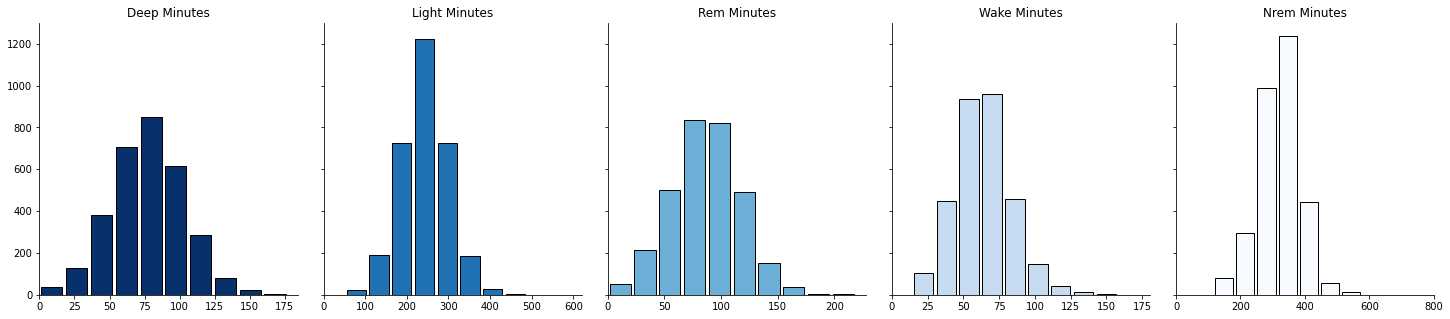

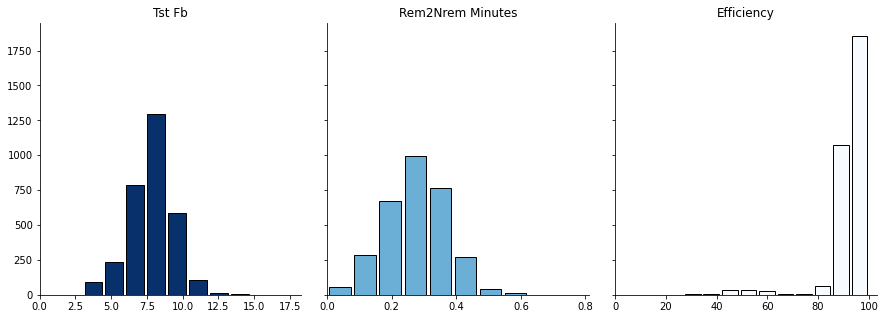

In [259]:
# Count metrics
sm_count = targets[[column for column in targets.columns if column.endswith("count") and "2" not in column]]
pp.plot_hist(sm_count)
# Minute metrics
sm_minutes = targets[[column for column in targets.columns if column.endswith("minutes") and "2" not in column]]
pp.plot_hist(sm_minutes)
# Other metrics
sm = targets[["tst_fb","rem2nrem_minutes","efficiency"]]
pp.plot_hist(sm)

<div class="alert alert-block alert-info">
    
Remarkably all but one of the sleep metric targets are normally distributed. The only metric that is not is `efficiency` which is _heavily_ skewed towards higher values, but we can try normalizing the efficiency values to use as a target instead.
    
</div>

#### Normalizing
There is little to no need to normalize the sleep metrics other than `efficiency`, but the code is generalized in case we want to go back.

Now we provide a function to transform a given dataframe.

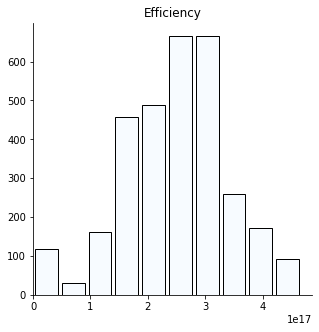

In [260]:
normalized_efficiency_only = pp.normalize(targets[["efficiency"]])
pp.plot_hist(normalized_efficiency_only)

The scaling has _dramatically_ increased the values of our data. However we can still see if normalizing produces some change in the effect of features on efficiency.

In [261]:
datasets = [features_ieq, features_mood, features_srsm, features_activity, labels]
for dataset in datasets:
    dataset["efficiency_normalized"] = pp.normalize(dataset[["efficiency"]]) # adding normalized efficiency to feature sets

## Feature Engineering
We follow along some basic guidelines that are outlined in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course on [Kaggle](https://www.kaggle.com). The general outline is given as follows:

- [Mutual Information](#mutual_information)
- [Clustering](#clustering)

Much of this code has been refractured into the `build_features` source code and we import that module below so that we can simplify the code presented in this notebook.

In [262]:
from src.features import build_features
# defining feature engineering object
fe = build_features.feature_engineering()

<a id='mutual_information'></a>

### Mutual Information
Using mutual information, we can get an initial insight into which features relate most closely with the sleep metric targets from Fitbit. This analysis only compares one feature to the target, but there might be more underlying relationships which we can explore further in later sections.

#### Test Case
The cells below are used to test the functionality of the code.

The first step is determine which features we want to include and which target we are interested in.

In [263]:
# defining
dataset = features_srsm
features = ["tst_ema","sol_ema","restful_ema"]
target = ["efficiency"]
# getting data
X, y = fe.get_datasets(original_dataset=dataset,feature_labels=features,target_labels=target)

Now we can get the Mutual Information (MI) scores for each of the features we are interested in.

In [264]:
mi_scores = fe.get_mi_scores(X, y, tolerance=0)

Now we can visually inspect the MI scores for each of the features in question.

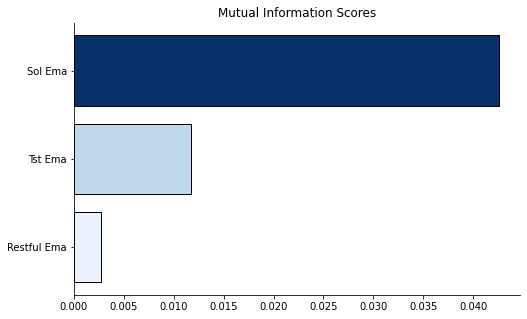

In [265]:
fe.plot_mi_scores(mi_scores)

The MI scores don't tell us what type of relationship, but we can examine it more by looking at a scatter plot of the values.

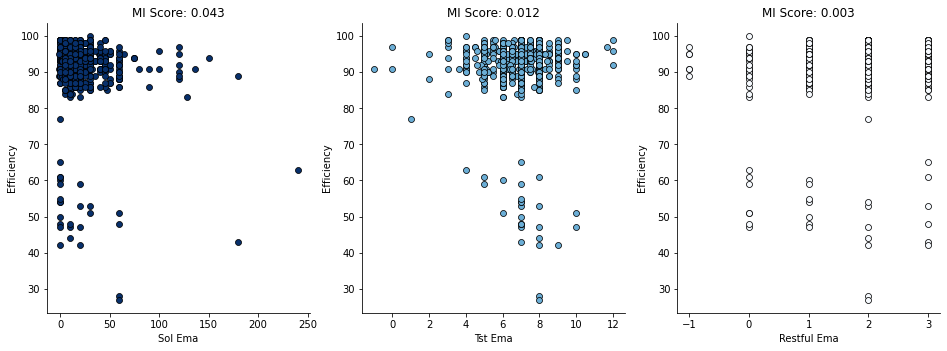

In [266]:
fe.plot_high_scoring_relationships(X, y, mi_scores, num_scores=3, width=16)

#### Application across feature sets
Now that we have working code, we can loop through all the feature sets and pull out the important information.

Dataset: IEQ
Target: Nrem Minutes


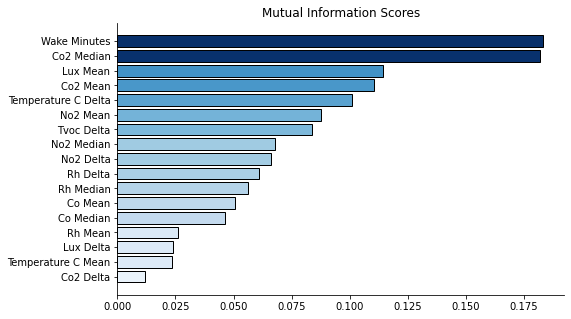

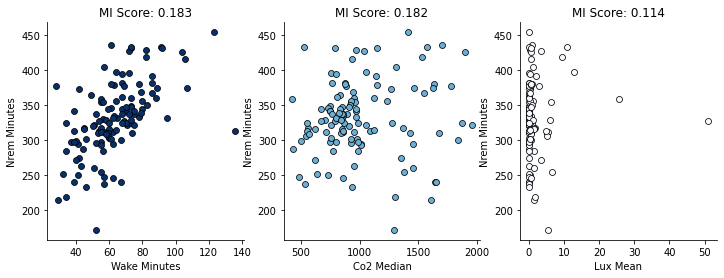

Target: Rem Minutes


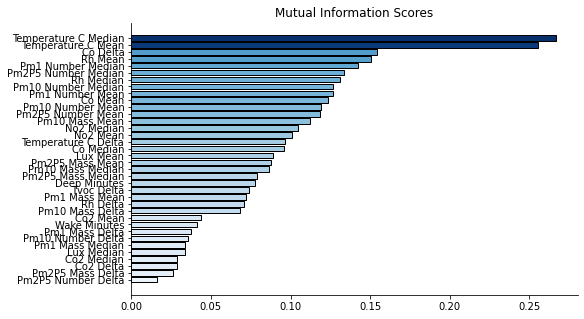

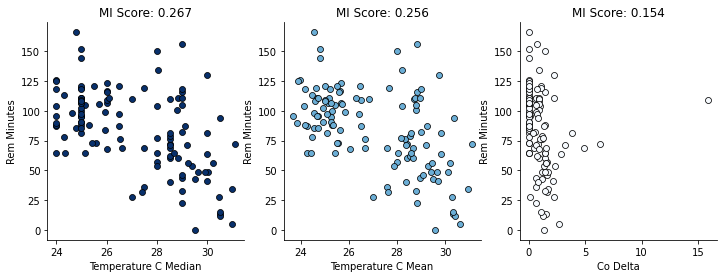

Target: Rem2Nrem Minutes


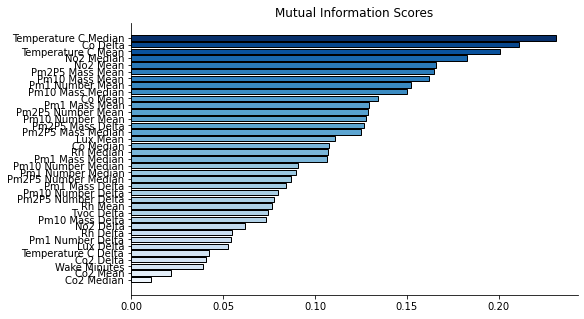

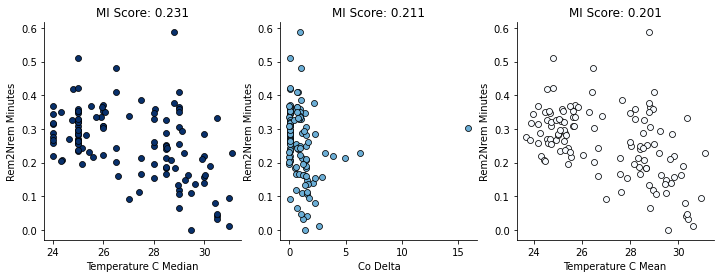

Target: Tst Fb


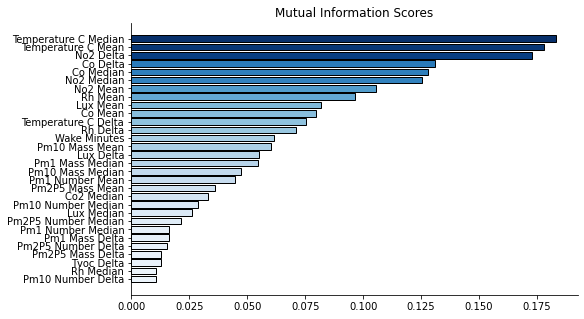

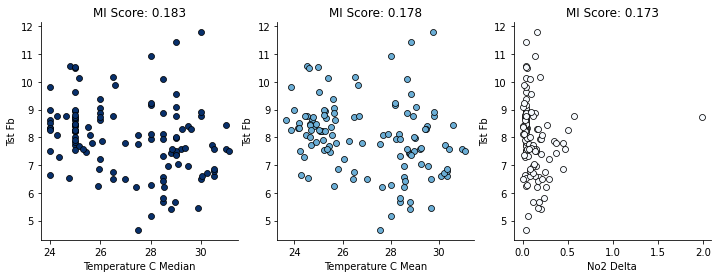

Target: Efficiency


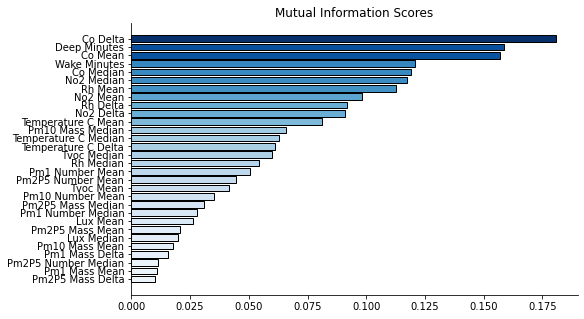

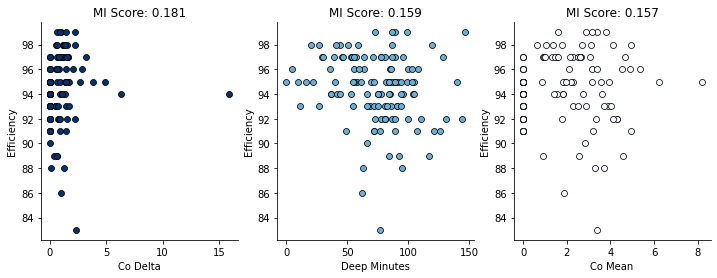

Target: Efficiency Normalized


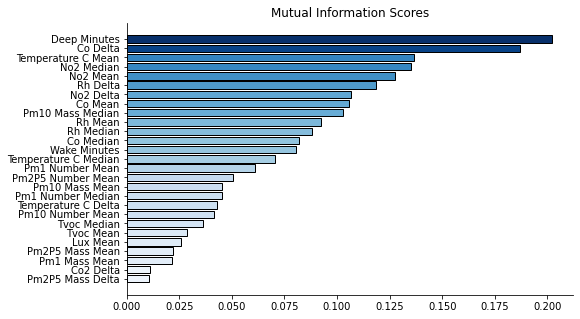

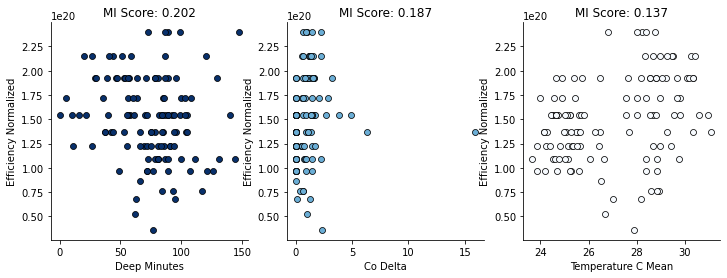

Dataset: Mood
Target: Nrem Minutes


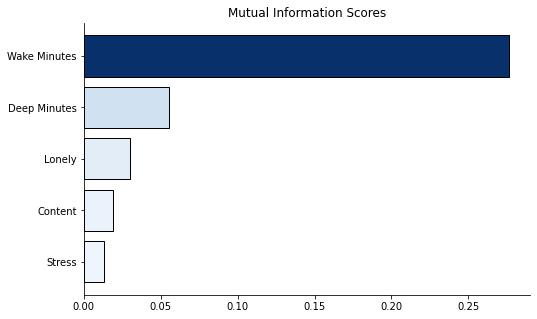

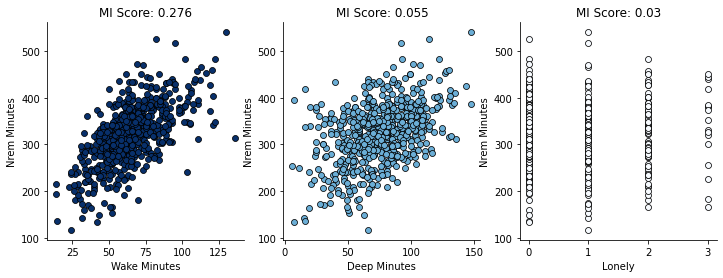

Target: Rem Minutes


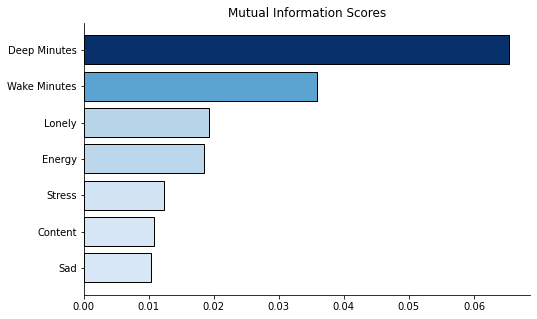

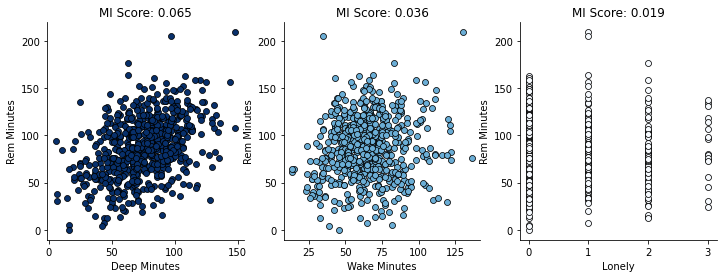

Target: Rem2Nrem Minutes


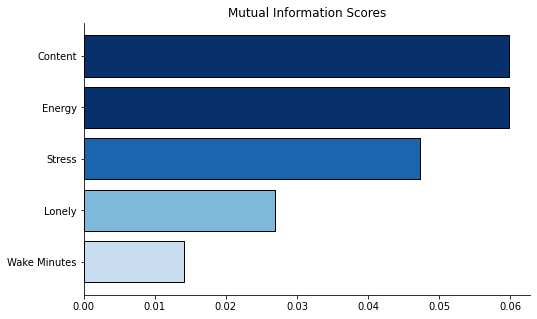

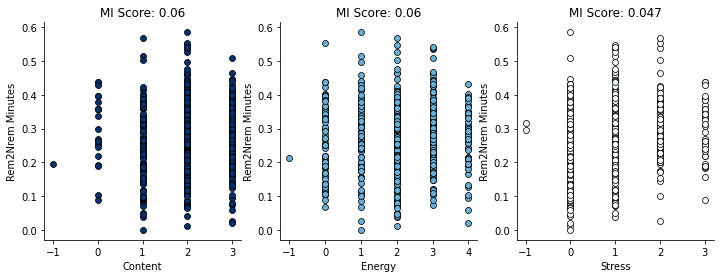

Target: Tst Fb


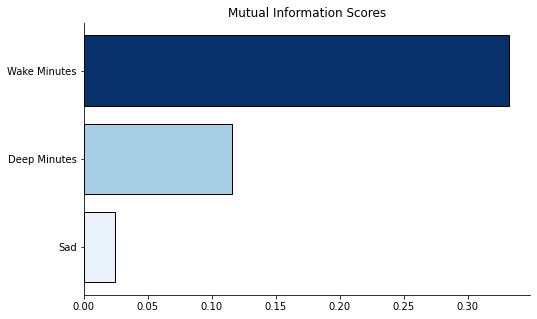

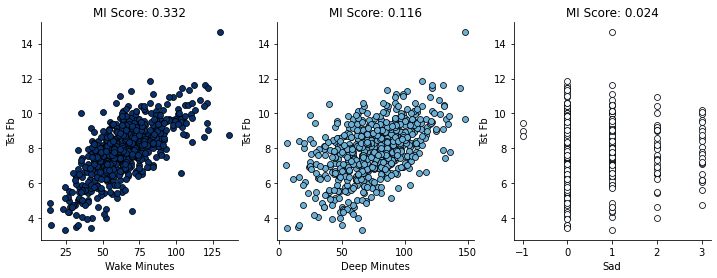

Target: Efficiency


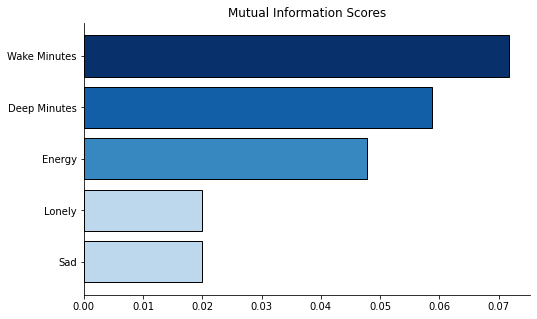

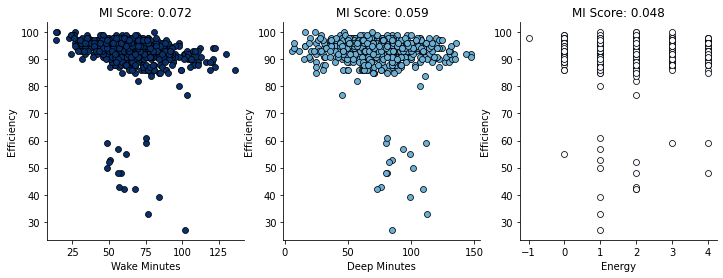

Target: Efficiency Normalized


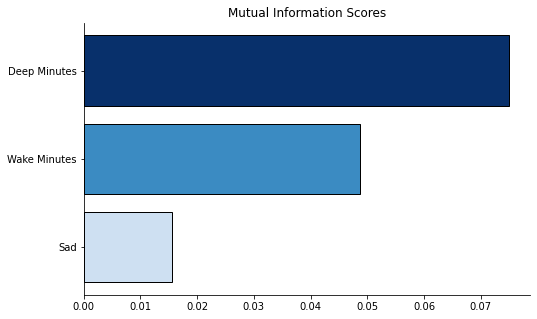

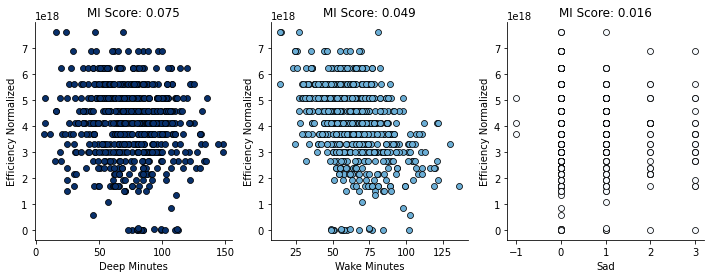

Dataset: Self-Report Sleep
Target: Nrem Minutes


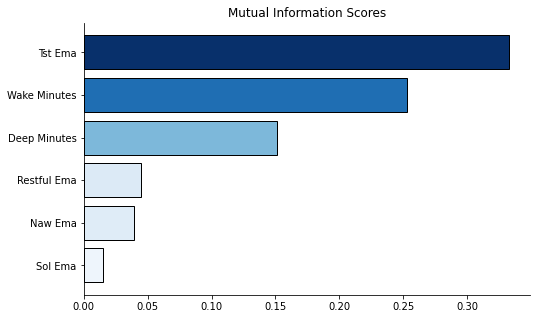

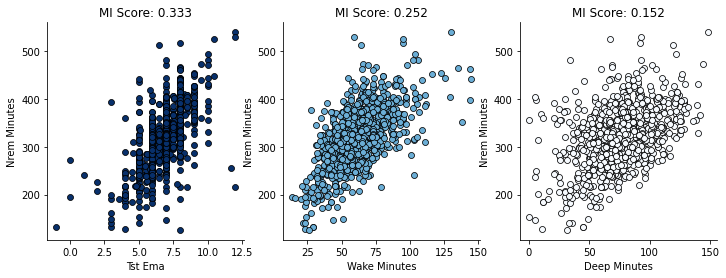

Target: Rem Minutes


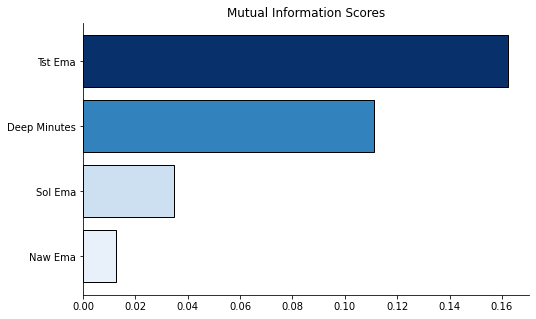

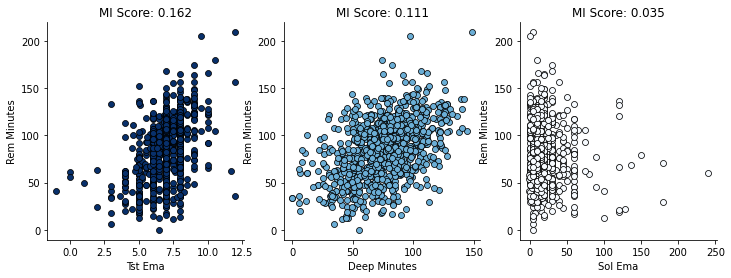

Target: Rem2Nrem Minutes


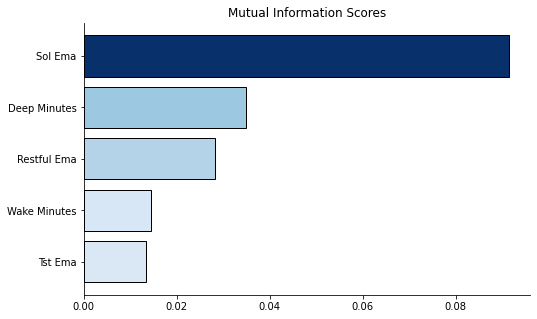

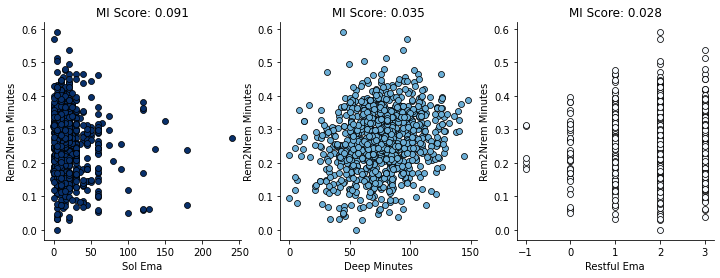

Target: Tst Fb


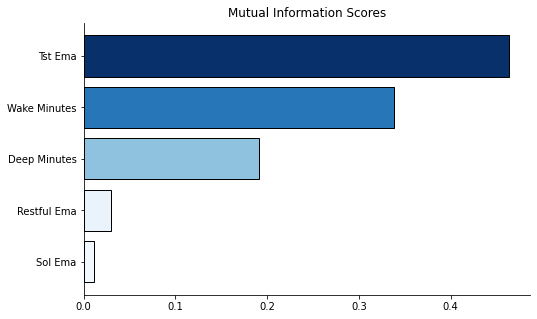

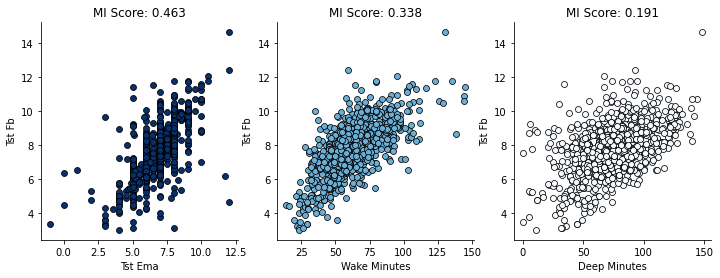

Target: Efficiency


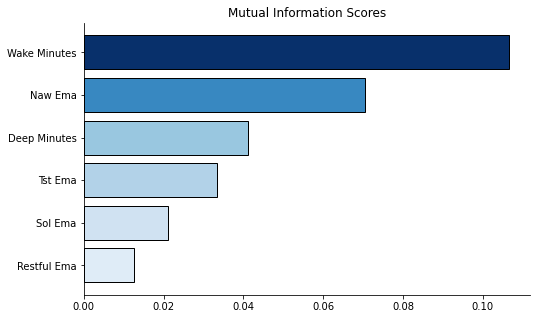

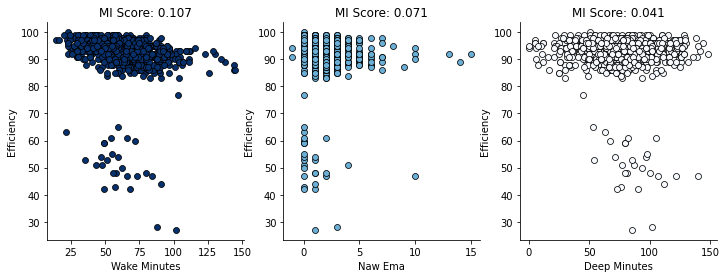

Target: Efficiency Normalized


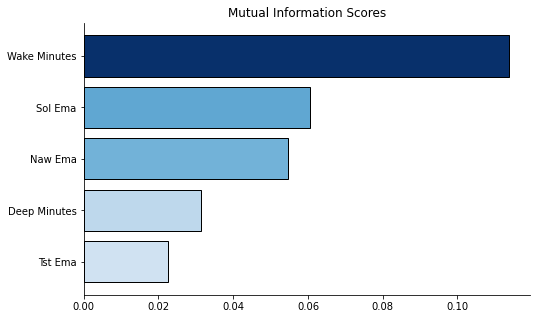

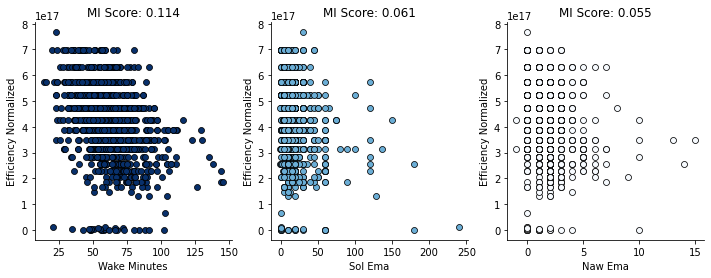

Dataset: Activity
Target: Nrem Minutes


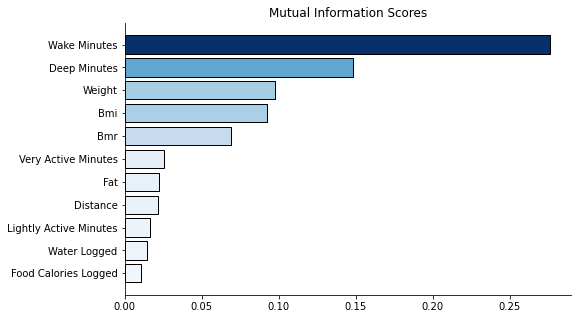

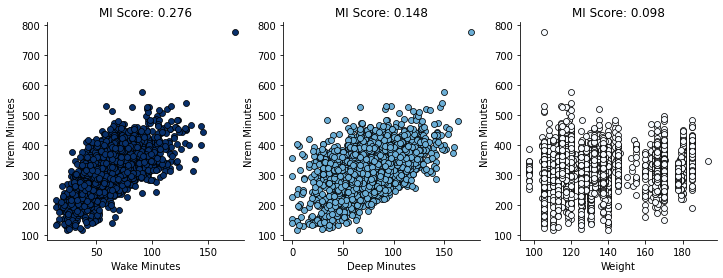

Target: Rem Minutes


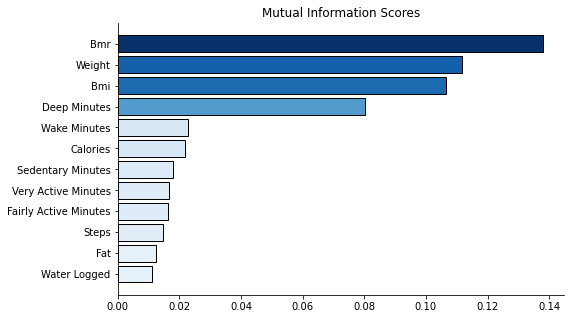

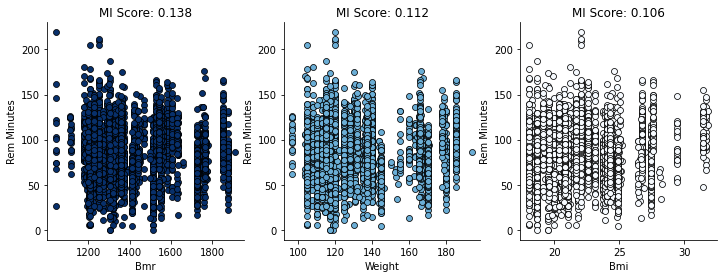

Target: Rem2Nrem Minutes


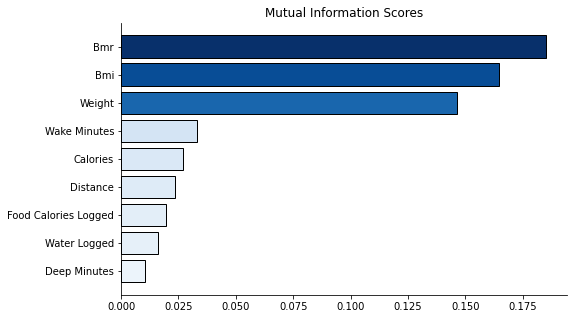

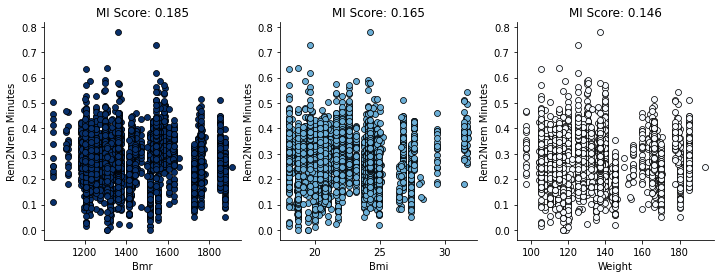

Target: Tst Fb


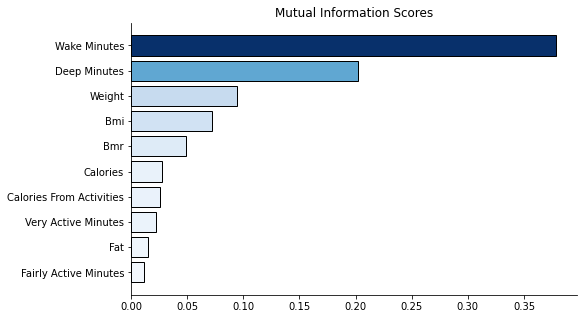

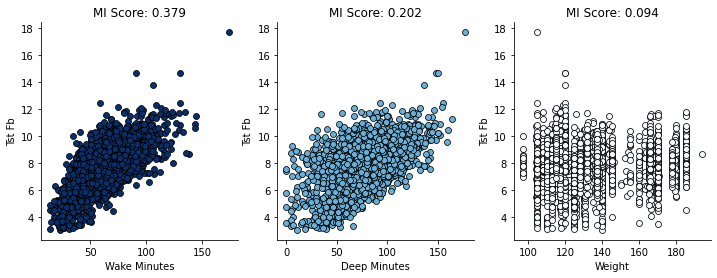

Target: Efficiency


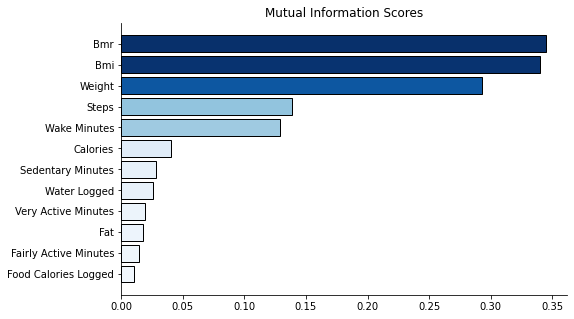

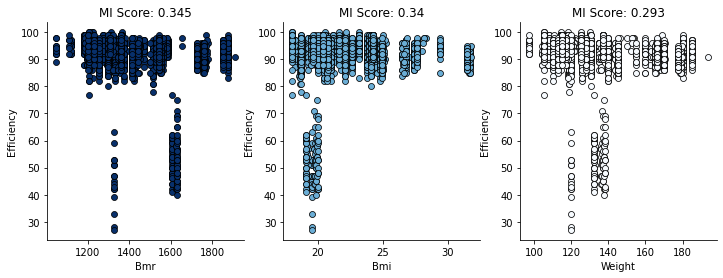

Target: Efficiency Normalized


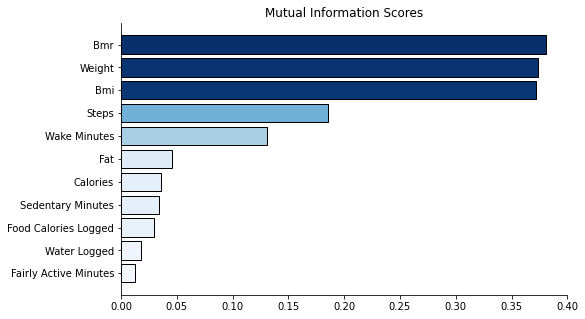

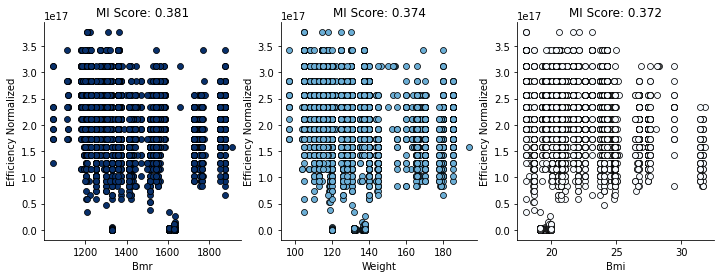

In [267]:
datasets = [features_ieq, features_mood, features_srsm, features_activity]
dataset_names = ["IEQ","Mood","Self-Report Sleep","Activity"]
nonfeatures = ["start_time","end_time","redcap","beiwe","beacon","fitbit","date","start_date","end_date","timestamp"]
vars_to_omit = [var for var in labels.columns if var.endswith("count")] + ["light_minutes","wake_minutes"]
target_labels = ["nrem_minutes","rem_minutes","rem2nrem_minutes","tst_fb","efficiency","efficiency_normalized"]
# looping through feature sets and targets
for dataset, name in zip(datasets, dataset_names):
    print(f"Dataset: {name}")
    temp = dataset.copy() # copying
    temp.drop(nonfeatures,axis="columns",errors="ignore",inplace=True) # dropping columns that are not features
    temp.drop(vars_to_omit,axis="columns",errors="ignore",inplace=True) # dropping unused features
    temp = temp.replace([np.inf, -np.inf], np.nan).dropna(axis="rows") # replacing NaNs and infs
    
    fe.check_features_against_targets(temp,target_labels)

<a id='clustering'></a>

### Clustering
Perhaps some of the features are better parsed into separate clusters. The following cells help look to see if clustering causes any changes in the effects of variables on the targets.

In [269]:
from sklearn.cluster import KMeans

The first use of clustering can be to define efficiency based on low and high values. Doing so will help get around the high efficiency values we got when we normalized the data earlier and provide a more natural break. 

In [270]:
datasets = [features_ieq, features_mood, features_srsm, features_activity, labels]
for dataset in datasets:
    # removing normalized efficiency if it is there
    try:
        dataset.drop(["efficiency_normalized"],axis="columns",inplace=True)
    except KeyError:
        print("efficiency_normalized not in dataset")
    # adding column to cluster efficiency
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
    dataset["efficiency_low"] = kmeans.fit_predict(np.array(dataset["efficiency"]).reshape(-1, 1))

In [271]:
def kmeans_cluster(df,n_clusters):
    """
    
    """
    kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
    df["cluster"] = kmeans.fit_predict(df)

In [272]:
temp = targets.copy()
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
temp["cluster"] = kmeans.fit_predict(np.array(temp["efficiency"]).reshape(-1, 1))